In [1]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from samples.CLS2IDX import CLS2IDX

# Auxiliary Functions

In [2]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained
model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = LRP(model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /home/chunwei/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


# Examples

## Cat-Dog

Top 5 classes:
	282 : tiger cat       		value = 10.559	 prob = 68.6%
	281 : tabby, tabby cat		value = 9.059	 prob = 15.3%
	285 : Egyptian cat    		value = 8.414	 prob = 8.0%
	243 : bull mastiff    		value = 7.425	 prob = 3.0%
	811 : space heater    		value = 5.152	 prob = 0.3%


/home/chunwei/anaconda3/envs/vis/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


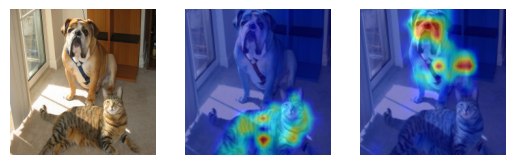

In [3]:
image = Image.open('samples/catdog.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(dog_cat_image)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=243)


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

## Tusker-Zebra

Top 5 classes:
	101 : tusker                              		value = 11.216	 prob = 37.9%
	340 : zebra                               		value = 10.973	 prob = 29.7%
	386 : African elephant, Loxodonta africana		value = 10.747	 prob = 23.7%
	385 : Indian elephant, Elephas maximus    		value = 9.547	 prob = 7.2%
	343 : warthog                             		value = 5.566	 prob = 0.1%


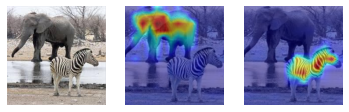

In [4]:
image = Image.open('samples/el2.png')
tusker_zebra_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(tusker_zebra_image.unsqueeze(0).cuda())
print_top_classes(output)

# tusker - the predicted class
tusker = generate_visualization(tusker_zebra_image)

# zebra 
# generate visualization for class 340: 'zebra'
zebra = generate_visualization(tusker_zebra_image, class_index=340)


axs[1].imshow(tusker);
axs[1].axis('off');
axs[2].imshow(zebra);
axs[2].axis('off');

In [11]:
image = Image.open('samples/dogbird.png')
dog_bird_image = transform(image)

print(dog_bird_image.shape)

torch.Size([3, 224, 224])


Top 5 classes:
	161 : basset, basset hound         		value = 10.514	 prob = 78.8%
	163 : bloodhound, sleuthhound      		value = 8.604	 prob = 11.7%
	166 : Walker hound, Walker foxhound		value = 7.446	 prob = 3.7%
	162 : beagle                       		value = 5.561	 prob = 0.6%
	168 : redbone                      		value = 5.249	 prob = 0.4%


/home/chunwei/anaconda3/envs/vis/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


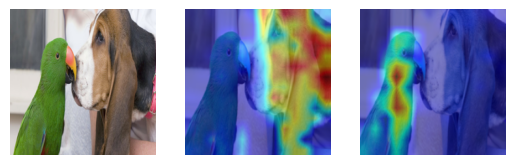

In [12]:


fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_bird_image.unsqueeze(0).cuda())
print_top_classes(output)

# basset - the predicted class
basset = generate_visualization(dog_bird_image, class_index=161)

# generate visualization for class 87: 'African grey, African gray, Psittacus erithacus (grey parrot)'
parrot = generate_visualization(dog_bird_image, class_index=87)


axs[1].imshow(basset);
axs[1].axis('off');
axs[2].imshow(parrot);
axs[2].axis('off');

In [19]:
import os
from pathlib import Path

flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
sample_path = flightmare_path / "flightpy/results/students/teacher_PPO_5/12-26-14-24-47/data/000/000437.npz"

image = np.load(sample_path)

image = Image.fromarray(image["rgb"].squeeze())

torch.Size([3, 224, 224])
Top 5 classes:
	884 : vault                                               		value = 7.544	 prob = 33.6%
	538 : dome                                                		value = 7.107	 prob = 21.7%
	421 : bannister, banister, balustrade, balusters, handrail		value = 5.263	 prob = 3.4%
	821 : steel arch bridge                                   		value = 4.513	 prob = 1.6%
	727 : planetarium                                         		value = 4.344	 prob = 1.4%


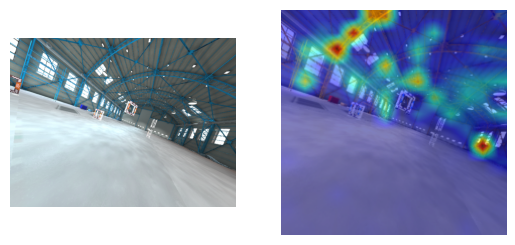

In [20]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image);
axs[0].axis('off');

image = transform(image)

print(image.shape)

output = model(image.unsqueeze(0).cuda())
print_top_classes(output)

# tusker - the predicted class
tusker = generate_visualization(image)

# zebra 
# generate visualization for class 340: 'zebra'
# zebra = generate_visualization(image, class_index=340)


axs[1].imshow(tusker);
axs[1].axis('off');
# axs[2].imshow(zebra);
# axs[2].axis('off');